In [2]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error



In [3]:
df = pd.read_csv('../ml/data/Housing.csv')

df

df.info()

df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

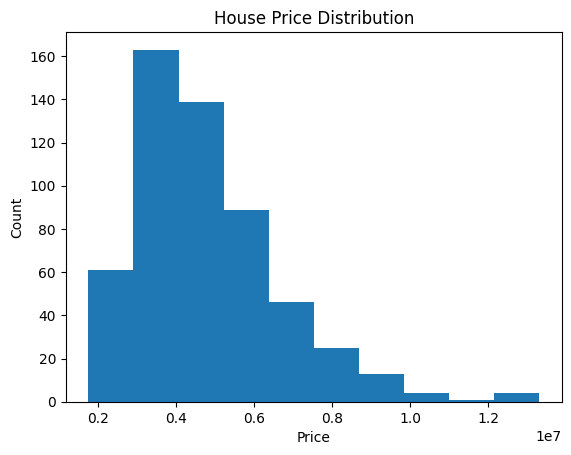

In [4]:
import matplotlib.pyplot as plt

plt.hist(df["price"], bins=10)
plt.title("House Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


In [5]:
X = df.drop(['price'], axis=1)
y = df['price']

In [21]:
X


,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...
540,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [6]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns

cat_features = X.select_dtypes(include=['object']).columns

In [7]:
num_transformer = StandardScaler()

cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
lr_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]
)

In [11]:
ridge_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', Ridge(alpha=1.0))
    ]
)

In [12]:
lasso_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', Lasso(alpha=0.01))
    ]
)

In [13]:
pipelines = {
    "Linear Regression": lr_pipeline,
    "Ridge Regression": ridge_pipeline,
    "Lasso Regression": lasso_pipeline
}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)


In [14]:


for name, pipe in pipelines.items():
    preds = pipe.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = root_mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(name)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R²:", r2)
    print()


Linear Regression
MSE: 1754318687330.6677
RMSE: 1324506.96009144
R²: 0.6529242642153177

Ridge Regression
MSE: 1758530862952.2075
RMSE: 1326096.0986867459
R²: 0.6520909242049432

Lasso Regression
MSE: 1754318718300.551
RMSE: 1324506.9717825388
R²: 0.6529242580882124



## Hyperparameter Tuning

In [15]:
from sklearn.model_selection import GridSearchCV

ridge_param_grid = {
    "model__alpha": [0.01, 0.1, 1, 10, 100]
}

ridge_grid = GridSearchCV(
    ridge_pipeline,
    ridge_param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

ridge_grid.fit(X_train, y_train)

print("Best Ridge alpha:", ridge_grid.best_params_)
print("Best Ridge RMSE:", -ridge_grid.best_score_)


Best Ridge alpha: {'model__alpha': 10}
Best Ridge RMSE: 1020266.0853359911


In [16]:
lasso_param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1]
}

lasso_grid = GridSearchCV(
    lasso_pipeline,
    lasso_param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

lasso_grid.fit(X_train, y_train)

print("Best Lasso alpha:", lasso_grid.best_params_)
print("Best Lasso RMSE:", -lasso_grid.best_score_)


Best Lasso alpha: {'model__alpha': 1}
Best Lasso RMSE: 1021776.3078420408


In [17]:
best_models = {
    "Linear Regression": lr_pipeline,
    "Ridge (Tuned)": ridge_grid.best_estimator_,
    "Lasso (Tuned)": lasso_grid.best_estimator_
}

for name, model in best_models.items():
    preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(name)
    print("RMSE:", rmse)
    print("R²:", r2)
    print()


Linear Regression
RMSE: 1324506.96009144
R²: 0.6529242642153177

Ridge (Tuned)
RMSE: 1338647.4717457795
R²: 0.6454739045516408

Lasso (Tuned)
RMSE: 1324508.1279824374
R²: 0.6529236521433269



## Model Diagonist

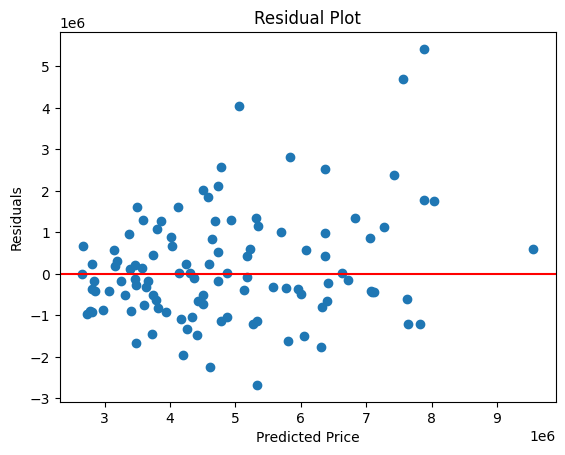

In [18]:
import matplotlib.pyplot as plt

best_model = ridge_grid.best_estimator_

preds = best_model.predict(X_test)
residuals = y_test - preds

plt.scatter(preds, residuals)
plt.axhline(0, color="red")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


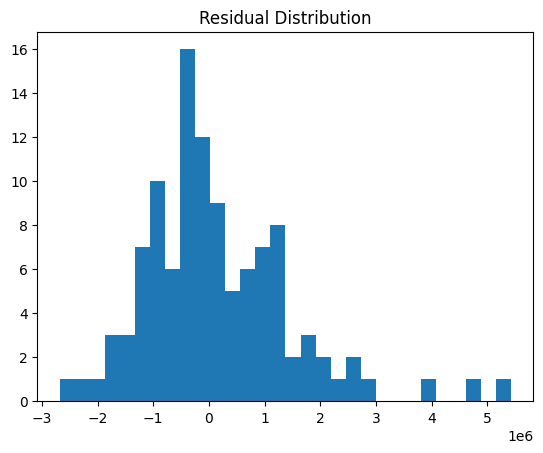

In [19]:
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.show()


In [20]:
final_model = ridge_grid.best_estimator_

ohe = final_model.named_steps["preprocessor"]\
    .named_transformers_["cat"]

cat_features = ohe.get_feature_names_out(cat_features)
all_features = np.concatenate([num_features, cat_features])

coefs = final_model.named_steps["model"].coef_

coef_df = pd.DataFrame({
    "Feature": all_features,
    "Coefficient": coefs
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
9,airconditioning_yes,704074.071759
10,prefarea_yes,566402.889782
0,area,522724.952845
2,bathrooms,515490.906348
8,hotwaterheating_yes,439685.682065
7,basement_yes,378974.945949
3,stories,355343.395974
5,mainroad_yes,331367.389542
6,guestroom_yes,230718.668938
4,parking,204827.518507
